In [34]:
# import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import datetime
import queue
import contextlib
import time
import pickle
# import PyQt5
# import statistics
from scipy.stats import skewnorm, pareto
from datetime import date
from abc import ABC
import json

In [35]:
# pip install PyQt5

#### Import the logs (backlog + incoming) from .CSV and create DataFrame

In [52]:
pl.Config.set_tbl_hide_dataframe_shape(True)

# log_df = pl.read_csv('datasets/defectRemediation_log_simulation_vPrototype_v2.csv')
log_df = pl.read_csv('datasets/testData5000.csv')
# log_df = log_df.with_columns(pl.col('Timestamp').str.strptime(pl.Datetime, '%Y-%d-%m %H:%M:%S'))
log_df = log_df.with_columns(pl.col('Timestamp').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S'))
log_df = log_df.with_columns(pl.col("Timestamp").dt.date().alias("Date"))
log_df = log_df.with_columns(pl.col("Timestamp").dt.hour().alias("Hour"))
# log_df = log_df[120:]
log_df

# log_df = pd.read_csv('defectRemediation_log_simulation_vPrototype_v2.csv', index_col='ID')
# log_df['Timestamp'] = pd.to_datetime(log_df['Timestamp'], format='%Y-%d-%m %H:%M:%S')
# log_df
# incoming_log_df = pl.read_csv('defectRemediation_log_incoming_simulation_vPrototype.csv')
# incoming_log_df['Timestamp'] = pl.to_datetime(incoming_log_df['Timestamp'], format='%Y-%d-%m %H:%M:%S')
# incoming_log_df

ID,Defect_ID,Control_Type,State,Timestamp,Date,Hour
i64,i64,str,str,datetime[μs],date,i8
1,1,"""ACC03""","""new""",2025-05-16 00:05:31,2025-05-16,0
2,2,"""ACC17""","""new""",2025-05-16 00:12:42,2025-05-16,0
3,3,"""ACC28""","""new""",2025-05-16 00:13:44,2025-05-16,0
4,1,"""ACC03""","""assign""",2025-05-16 00:18:57,2025-05-16,0
5,1,"""ACC03""","""in-progress""",2025-05-16 00:22:43,2025-05-16,0
…,…,…,…,…,…,…
4996,1249,"""ACC28""","""closed""",2026-10-28 06:44:59,2026-10-28,6
4997,1250,"""ACC28""","""new""",2026-10-28 11:19:59,2026-10-28,11
4998,1250,"""ACC28""","""assign""",2026-10-28 15:15:59,2026-10-28,15


#### Fill in delta table based on log entries in snapshot

In [4]:
class logEntry:
    def __init__(self, row_id, sub_log_df, sub_deltas_dict):
        self.defect_id = sub_log_df.filter(pl.col('ID')==row_id)['Defect_ID'][0]
        self.state = sub_log_df.filter(pl.col('ID')==row_id)['State'][0]
        self.control_type = sub_log_df.filter(pl.col('ID')==row_id)['Control_Type'][0]
        self.sub_log_df = sub_log_df
        self.sub_deltas_dict = sub_deltas_dict

    def checkState(self, empirical_dict):
        if self.state == 'new':
            ## append to delta table with defect_ID and control_type
            self.sub_deltas_dict[self.defect_id] = {'Defect_ID': self.defect_id,
                                                    'Control_Type': self.control_type,
                                                    'Delta_New_Assign': float('nan'),
                                                    'Delta_Assign_InProgress': float('nan'),
                                                    'Delta_InProgress_Closed': float('nan'),
                                                    'Delta_New_Closed': float('nan'),
                                                   }
            # self.sub_deltas_df[index, ['Defect_ID', 'Control_Type']] = [self.defect_id, self.control_type]
            # index += 1

        elif self.state =='assign':
            delta_new_assign, empirical_dict = self.stateAssign(empirical_dict)
            self.sub_deltas_dict[self.defect_id].update({'Delta_New_Assign': delta_new_assign})
            # deltas_df.loc[deltas_df['Defect_ID'] == self.defect_id, 'Delta_New_Assign'] = delta_new_assign
    
            # log_entry.updateDeltaTable(delta_new_assign, sub_deltas_df)

        elif self.state == 'in-progress':
            delta_assign_inprogress, empirical_dict = self.stateInProgress(empirical_dict)
            self.sub_deltas_dict[self.defect_id].update({'Delta_Assign_InProgress': delta_assign_inprogress})
            # deltas_df.loc[deltas_df['Defect_ID'] == self.defect_id, 'Delta_Assign_InProgress'] = delta_assign_inprogress
        
        elif self.state == 'closed':
            delta_inprogress_closed, delta_new_closed, empirical_dict = self.stateClosed(empirical_dict)
            self.sub_deltas_dict[self.defect_id].update({'Delta_InProgress_Closed': delta_inprogress_closed, 'Delta_New_Closed': delta_new_closed})
            # deltas_df.loc[deltas_df['Defect_ID'] == self.defect_id, ['Delta_InProgress_Closed', 'Delta_New_Closed']] = [delta_inprogress_closed, delta_new_closed]
        
        return self.sub_deltas_dict, empirical_dict

# def stateNew(self):
## create new delta table row

    def stateAssign(self, empirical_dict):
        timestamp_new = self.sub_log_df.filter(pl.col('Defect_ID')==self.defect_id, pl.col('State')=='new')['Timestamp'][0]
        timestamp_assign = self.sub_log_df.filter(pl.col('Defect_ID')==self.defect_id, pl.col('State')==self.state)['Timestamp'][0]
        # timestamp_new = self.sub_log_df.loc[(self.sub_log_df['Defect_ID']==self.defect_id) & (self.sub_log_df['State']=='new')]['Timestamp'].iloc[0]
        # timestamp_assign = self.sub_log_df.loc[(self.sub_log_df['Defect_ID']==self.defect_id) & (self.sub_log_df['State']==self.state)]['Timestamp'].iloc[0]
        
        ## time between assign and new (hrs)
        delta_new_assign = self.computeDelta(timestamp_new, timestamp_assign)
        
        ## append value to empirical dict
        empirical_dict[self.control_type]['delta_new_assign'].append(delta_new_assign)
        return delta_new_assign, empirical_dict
    
    def stateInProgress(self, empirical_dict):
        timestamp_assign = self.sub_log_df.filter(pl.col('Defect_ID')==self.defect_id, pl.col('State')=='assign')['Timestamp'][0]
        timestamp_inprogress = self.sub_log_df.filter(pl.col('Defect_ID')==self.defect_id, pl.col('State')==self.state)['Timestamp'][0]
        # timestamp_assign = self.sub_log_df.loc[(self.sub_log_df['Defect_ID']==self.defect_id) & (self.sub_log_df['State']=='assign')]['Timestamp'].iloc[0]
        # timestamp_inprogress = self.sub_log_df.loc[(self.sub_log_df['Defect_ID']==self.defect_id) & (self.sub_log_df['State']==self.state)]['Timestamp'].iloc[0]
        
        ## time between in-progress and assign (hrs)
        delta_assign_inprogress = self.computeDelta(timestamp_assign, timestamp_inprogress)
        
        ## append value to empirical dict
        empirical_dict[self.control_type]['delta_assign_inprogress'].append(delta_assign_inprogress)
        return delta_assign_inprogress, empirical_dict
    
    def stateClosed(self, empirical_dict):
        timestamp_new = self.sub_log_df.filter(pl.col('Defect_ID')==self.defect_id, pl.col('State')=='new')['Timestamp'][0]
        timestamp_inprogress = self.sub_log_df.filter(pl.col('Defect_ID')==self.defect_id, pl.col('State')=='in-progress')['Timestamp'][0]
        timestamp_closed = self.sub_log_df.filter(pl.col('Defect_ID')==self.defect_id, pl.col('State')==self.state)['Timestamp'][0]
        
        ## time between closed and in-progress, and closed and new (hrs)
        delta_inprogress_closed = self.computeDelta(timestamp_inprogress, timestamp_closed)
        delta_new_closed = self.computeDelta(timestamp_new, timestamp_closed)
        
        ## append value to empirical dict
        empirical_dict[self.control_type]['delta_inprogress_closed'].append(delta_inprogress_closed)
        empirical_dict[self.control_type]['delta_new_closed'].append(delta_new_closed)
        return delta_inprogress_closed, delta_new_closed, empirical_dict
    
     # def updateDeltaTable(self, delta_state_state):
    def computeDelta(self, timestamp_older, timestamp_newer):
        ## Computes the time delta (in hrs) as timestamp_newer - timestamp_older
        delta_timestamps = timestamp_newer - timestamp_older
        delta_timestamps = round(delta_timestamps.total_seconds()/3600, 3)
        return delta_timestamps

#### Update histograms each snapshot

In [70]:
class buildHistories:
    def __init__(self, control_type, sub_log_df, sub_deltas_df, incoming_dict, outgoing_dict, empirical_dict):
        self.control_type = control_type
        
        ## only need state == 'new' for incoming defects per hour histograms, state == 'closed' for outgoing defects per hour histograms
        self.sub_log_df_inc = sub_log_df.filter(pl.col('State') == "new")
        self.sub_log_df_out = sub_log_df.filter(pl.col('State') == "closed")

        self.sub_deltas_df = sub_deltas_df
        self.incoming_dict = incoming_dict
        self.outgoing_dict = outgoing_dict
        self.empirical_dict = empirical_dict
        self.VizUtils = VizUtils()

    def update_figures(self):
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
        deltas = ['Delta_New_Assign', 'Delta_Assign_InProgress', 'Delta_InProgress_Closed', 'Delta_New_Closed']
        ylabels = ['time (hrs)', None, None, None]
        for index in range(4):
            xdata = range(1,len(self.sub_deltas_df.select(deltas[index])) + 1)
            ydata = self.sub_deltas_df.select(deltas[index])
            fig, axs = self.VizUtils.visualize_timeline(fig, axs, index, xdata, ydata, ylabel=ylabels[index], title=deltas[index])
        
        # axs[0].plot(range(1,len(self.sub_deltas_df.select('Delta_New_Assign'))+1), self.sub_deltas_df.select('Delta_New_Assign'), 'k-o', markersize=6)
        # axs[0].set_ylabel('time (hrs)')
        # axs[0].set_title('Delta_New_Assign', loc='left', fontsize=10)

        # axs[1].plot(range(1,len(self.sub_deltas_df.select('Delta_Assign_InProgress'))+1), self.sub_deltas_df.select('Delta_Assign_InProgress'), 'k-o', markersize=6)
        # axs[1].set_title('Delta_Assign_InProgress', loc='left', fontsize=10)

        # axs[2].plot(range(1,len(self.sub_deltas_df.select('Delta_InProgress_Closed'))+1), self.sub_deltas_df.select('Delta_InProgress_Closed'), 'k-o', markersize=6)
        # axs[2].set_title('Delta_InProgress_Closed', loc='left', fontsize=10)

        # axs[3].plot(range(1,len(self.sub_deltas_df.select('Delta_New_Closed'))+1), self.sub_deltas_df.select('Delta_New_Closed'), 'k-o', markersize=6)
        # axs[3].set_title('Delta_New_Closed', loc='left', fontsize=10)
    
        fig.text(0.5, 0.95, f'{self.control_type}', ha='center', fontsize=12)
        plt.savefig(f'figures/{self.control_type}_fig_{date.today()}.png', bbox_inches='tight')
        plt.close()

    # def deltaDistributions(self):

    def updateIncoming(self):
        for day in self.sub_log_df_inc["Date"].unique(): # TO DO - how to track date outside of logs (i.e. if no state changes/defects generated, dates do not appear in logs 
            sub_log_df_inc_date = self.sub_log_df_inc.filter(pl.col('Date') == day)['Hour'].value_counts()
            incoming_defects = [sub_log_df_inc_date.filter(pl.col('Hour') == i)['count'][0] if i in list(sub_log_df_inc_date.select('Hour'))[0] else 0 for i in range(0,24)]
            self.incoming_dict[control_type].update({day: incoming_defects})
            self.empirical_dict[control_type]['incoming_per_hour'] = self.empirical_dict[control_type]['incoming_per_hour'] + self.incoming_dict[control_type][day]
        return self.incoming_dict, self.empirical_dict
    
    def updateOutgoing(self):
        for day in self.sub_log_df_out["Date"].unique(): # will never be empty 
            sub_log_df_out_date = self.sub_log_df_out.filter(pl.col('Date') == day)['Hour'].value_counts()
            outgoing_defects = [sub_log_df_out_date.filter(pl.col('Hour') == i)['count'][0] if i in list(sub_log_df_out_date.select('Hour'))[0] else 0 for i in range(0,24)]
            self.outgoing_dict[control_type].update({day: outgoing_defects})
            self.empirical_dict[control_type]['outgoing_per_hour'] = self.empirical_dict[control_type]['outgoing_per_hour'] + self.outgoing_dict[control_type][day]
        return self.outgoing_dict, self.empirical_dict

    def update_delta_distributions(self):
        fig, axs = plt.subplots (1, 4, figsize=(16,4))
        deltas = ['Delta_New_Assign', 'Delta_Assign_InProgress', 'Delta_InProgress_Closed', 'Delta_New_Closed']
        for index in range(4):
            data = self.empirical_dict[self.control_type][deltas[index].lower()]
            fig, axs = self.VizUtils.visualize_delta_histograms(fig, 
                                                                 axs, index,data,label=None,title=deltas[index], color='#2449FF')
        plt.savefig(f'figures/{self.control_type}_delta_histograms_{date.today()}.png', bbox_inches='tight')
        plt.close()
    
    def update_incoming_outgoing_distributions(self):
        fig, axs = plt.subplots (1, 1, figsize=(8,4))
        # incoming_per_hour histogram
        data_incoming = np.array(self.empirical_dict[self.control_type]['incoming_per_hour'])
        fig, axs = self.VizUtils.visualize_histograms_theory(fig, axs, data_incoming, label='incoming', title=f'{self.control_type} incoming [/hr]', color='#2449FF')
        # outgoing_per_hour histogram
        data_outgoing = np.array(self.empirical_dict[self.control_type]['outgoing_per_hour'])
        fig, axs = self.VizUtils.visualize_histograms_theory(fig, axs, data_outgoing, label='outgoing', title=f'{self.control_type} outgoing [/hr]', color='#087A8E', step=True)
        plt.savefig(f'figures/{self.control_type}_histograms_{date.today()}.png', bbox_inches='tight')
        plt.close()
        
        # unique_values = np.unique(data_incoming)
        # if np.all(unique_values) == 0:
        #     d = 1
        # else:
        #     d = np.diff(unique_values).min()
        # left_of_first_bin = data_incoming.min() - float(d)/2
        # right_of_last_bin = data_incoming.max() + float(d)/2
        # axs[0].hist(data_incoming, np.arange(left_of_first_bin, right_of_last_bin + d, d), label='incoming', color='maroon', alpha=0.2, edgecolor='black', linewidth=1.5, density=True)
        # axs[0].set_title(f'{self.control_type}', loc='left', fontsize=14, **csfont)
    
         
        
        # unique_values = np.unique(data_outgoing)
        # if np.all(unique_values) == 0:
        #     d = 1
        # else:
        #     d = np.diff(unique_values).min()
        # left_of_first_bin = data_outgoing.min() - float(d)/2
        # right_of_last_bin = data_outgoing.max() + float(d)/2
        # axs[0].hist(data_outgoing, np.arange(left_of_first_bin, right_of_last_bin + d, d), label='outgoing', histtype='step', linewidth=1.5, density=True)
        # # axs[index][0].set_title(f'{value}', loc='left', fontsize=14, **csfont)
        # axs[0].legend(fontsize='small')
        
        # delta histograms
        # axs[1].hist(self.empirical_dict[self.control_type]['delta_new_assign'], bins=3, edgecolor='black', linewidth=1.5, density=True)
        # axs[2].hist(self.empirical_dict[self.control_type]['delta_assign_inprogress'], bins=3, edgecolor='black', linewidth=1.5, density=True)
        # axs[3].hist(self.empirical_dict[self.control_type]['delta_inprogress_closed'], bins=3, edgecolor='black', linewidth=1.5, density=True)
        # axs[4].hist(self.empirical_dict[self.control_type]['delta_new_closed'], bins=3, edgecolor='black', linewidth=1.5, density=True)
    
        # axs[1].set_title('Delta_New_Assign', loc='left', fontsize=12, **csfont)
        # axs[2].set_title('Delta_Assign_InProgress', loc='left', fontsize=12, **csfont)
        # axs[3].set_title('Delta_InProgress_Closed', loc='left', fontsize=12, **csfont)
        # axs[4].set_title('Delta_New_Closed', loc='left', fontsize=12, **csfont)
        
        

In [71]:
class VizUtils:
    def __init__(self):
        pass

    def visualize_delta_histograms(self, fig, axs, index, data, label=None, title=None, color='black', step=False):
        csfont = {'fontname':'Arial'}
        data = np.array(data)
        unique_values = np.unique(data)
        d = 1 if np.all(unique_values) == 0 else np.diff(unique_values).min()
        left_of_first_bin = data.min() - float(d)/2
        right_of_last_bin = data.max() + float(d)/2

        axs[index].hist(data,
                        bins=10,
                        label=label,
                        linewidth=1.5,
                        density=True,
                        color=color,
                        alpha=0.5,
                        edgecolor='black')
        if title:
            axs[index].set_title(title, loc='left', fontsize=12, **csfont)
        return fig, axs
        
    def visualize_histograms_theory(self, fig, axs, data, label=None, title=None, color='black', step=False):
        csfont = {'fontname':'Arial'}
        data = np.array(data)
        unique_values = np.unique(data)
        d = 1 if np.all(unique_values) == 0 else np.diff(unique_values).min()
        left_of_first_bin = data.min() - float(d)/2
        right_of_last_bin = data.max() + float(d)/2

        if step:
            axs.hist(data,
                        np.arange(left_of_first_bin, right_of_last_bin + d, d),
                        label=label,
                        linewidth=2,
                        density=True,
                        color=color,
                        histtype='step')
        else:
            axs.hist(data,
                            np.arange(left_of_first_bin, right_of_last_bin + d, d),
                            label=label,
                            linewidth=1.5,
                            density=True,
                            color=color,
                            alpha=0.5,
                            edgecolor='black')
        if title:
            axs.set_title(title, loc='left', fontsize=12, **csfont)
        return fig, axs

    def visualize_histograms_samples(self):
        pass

    def visualize_boxplots(self):
        pass

    def visualize_timeline(self, fig, axs, index, xdata, ydata, ylabel=None, title=None):
        axs[index].plot(xdata, ydata, 'k-o', markersize=6)
        if ylabel:
            axs[index].set_ylabel(ylabel)
        if title:
            axs[index].set_title(title, loc='left', fontsize=10)
        return fig, axs

#### Answer questions about the snapshot

In [7]:
class answeringQuestions:
    def __init__(self, control_type, sub_log_df, sub_deltas_df, incoming_dict, outgoing_dict):
        self.control_type = control_type
        self.sub_log_df = sub_log_df
        self.sub_deltas_df = sub_deltas_df
        self.incoming_dict = incoming_dict
        self.outgoing_dict = outgoing_dict

    def generated_per_hour(self):
        sub_log_df_inc = self.sub_log_df.filter(pl.col('State') == "new")
        means_inc_dict = {day: np.mean(self.incoming_dict[self.control_type][day]) for day in sub_log_df_inc["Date"].unique()}
        return means_inc_dict

    def generated_per_day(self):
        sub_log_df_inc = self.sub_log_df.filter(pl.col('State') == "new")
        means_inc_dict = {day: np.sum(self.incoming_dict[self.control_type][day]) for day in sub_log_df_inc["Date"].unique()}
        return means_inc_dict
        
    def remediated_per_hour(self):
        sub_log_df_out = self.sub_log_df.filter(pl.col('State') == "closed")
        means_out_dict = {day: np.mean(self.outgoing_dict[self.control_type][day]) for day in sub_log_df_out["Date"].unique()}
        return means_out_dict

    def remediated_per_day(self):
        sub_log_df_out = self.sub_log_df.filter(pl.col('State') == "closed")
        means_out_dict = {day: np.sum(self.outgoing_dict[self.control_type][day]) for day in sub_log_df_out["Date"].unique()}
        return means_out_dict
    
    def total_remediation_time(self):
        mean_new_closed = self.sub_deltas_df.select('Delta_New_Closed').mean().item()
        return mean_new_closed
        
    def waiting_in_backlog_time(self):
        # we consider a defect to be removed from the backlog when it is assigned
        mean_new_assign = self.sub_deltas_df.select('Delta_New_Assign').mean().item()
        return mean_new_assign
        
    def state_changes_tracking(self):
        mean_new_assign = self.sub_deltas_df.select('Delta_New_Assign').mean().item()
        mean_assign_inprogress = self.sub_deltas_df.select('Delta_Assign_InProgress').mean().item()
        mean_inprogress_closed = self.sub_deltas_df.select('Delta_InProgress_Closed').mean().item()
        return mean_new_assign, mean_assign_inprogress, mean_inprogress_closed

#### 1 class per control type

In [8]:
class DefectType(ABC):
    def __init__(self, control_type, sub_log_df):
        self.control_type = control_type
        self.sub_log_df = sub_log_df

    def updateDeltaTable(self, empirical_dict):
        processing_queue = queue.Queue()
        self.sub_deltas_df = pl.DataFrame(schema=[('Defect_ID',int),('Control_Type',str),('Delta_New_Assign',float),('Delta_Assign_InProgress',float),('Delta_InProgress_Closed',float), ('Delta_New_Closed',float)])
        sub_deltas_dict = {}
        for row in self.sub_log_df.iter_rows():
            # self.sub_log_df.loc[row[0], 'Date'] = self.sub_log_df.loc[row[0], 'Timestamp'].date()
            # self.sub_log_df.loc[row[0], 'Hour'] = self.sub_log_df.loc[row[0], 'Timestamp'].hour
            with contextlib.suppress(IndexError):
                processing_queue.put(row[0], block=False)

        while processing_queue.qsize() > 0: # takes previous 24h of data
            # for _ in range(processing_queue.qsize()):
            with contextlib.suppress(queue.Empty):
                row_id = processing_queue.get(block=False)
            log_entry = logEntry(row_id, self.sub_log_df, sub_deltas_dict)
            sub_deltas_dict, empirical_dict = log_entry.checkState(empirical_dict)
        for key in sub_deltas_dict.keys():
            self.sub_deltas_df.extend(pl.DataFrame(sub_deltas_dict[key]))
        return self.sub_deltas_df, empirical_dict

    def updateHistograms(self, deltas_df, incoming_dict, outgoing_dict, empirical_dict):
        sub_deltas_df = deltas_df.filter(pl.col('Control_Type') == self.control_type).drop_nans()
        histories = buildHistories(self.control_type, self.sub_log_df, sub_deltas_df, incoming_dict, outgoing_dict, empirical_dict)
        if sub_deltas_df.is_empty() == 0:
            histories.update_figures() ## update the delta figures for this control type
            incoming_dict, empirical_dict = histories.updateIncoming() ## update incoming defect distributions for this control_type
            # histories.updateIncoming() ## update incoming defect distributions for this control_type
            outgoing_dict, empirical_dict = histories.updateOutgoing() ## update outgoing defect distributions for this control_type
            histories.update_delta_distributions()
            histories.update_incoming_outgoing_distributions()
        return incoming_dict, outgoing_dict, empirical_dict

    def answerQuestions(self, deltas_df, incoming_dict, outgoing_dict):
        sub_deltas_df = deltas_df.filter(pl.col('Control_Type') == self.control_type).drop_nans()
        questions = answeringQuestions(self.control_type, self.sub_log_df, sub_deltas_df, incoming_dict, outgoing_dict)
        return questions

In [9]:
class ACC03(DefectType):
    def __init__(self, sub_log_df_ACC03):
        super().__init__('ACC03', sub_log_df_ACC03)
        # self.control_type = 'ACC03'
        # self.sub_log_df = sub_log_df_ACC03

class ACC17(DefectType):
    def __init__(self, sub_log_df_ACC17):
        super().__init__('ACC17', sub_log_df_ACC17)

class ACC28(DefectType):
    def __init__(self, sub_log_df_ACC28):
        super().__init__('ACC28', sub_log_df_ACC28)

class AUTH18(DefectType):
    def __init__(self, sub_log_df_AUTH18):
        super().__init__('AUTH18', sub_log_df_AUTH18)

class AUTH42(DefectType):
    def __init__(self, sub_log_df_AUTH42):
        super().__init__('AUTH42', sub_log_df_AUTH42)

## Run simulation

In [72]:
# master dictionary with tracked empirical data to build distributions
empirical_dict = {}
incoming_dict = {}
outgoing_dict = {}
control_types = log_df['Control_Type'].unique()
for control_type in control_types:
    empirical_dict[control_type] = {'incoming_per_hour': [],
                                    'outgoing_per_hour': [],
                                    'delta_new_assign': [],
                                    'delta_assign_inprogress': [],
                                    'delta_inprogress_closed': [],
                                    'delta_new_closed': []
                                   }
    incoming_dict[control_type] = {}
    outgoing_dict[control_type] = {}

# initializing empty delta table
deltas_df = pl.DataFrame(schema=[('Defect_ID',int),('Control_Type',str),('Delta_New_Assign',float),('Delta_Assign_InProgress',float),('Delta_InProgress_Closed',float), ('Delta_New_Closed',float)])

In [73]:
# try: ## deltas_df contains some entries, add onto it
#     Last_ID_processed = deltas_df[-1, 'Defect_ID']
#     index = Last_ID_processed + 1
# except IndexError: ## deltas_df is empty, start from beginning
#     index = 0 

# control_types = ["ACC03"] 
# control_types = ["AUTH18"] 
# control_types = ["ACC03", "AUTH42"] 
for control_type in control_types:
    sub_log_df = log_df.filter(pl.col('Control_Type') == control_type)
    exec("instance = " + control_type + "(sub_log_df)") # or ast.eval ?
    sub_deltas_df, empirical_dict = instance.updateDeltaTable(empirical_dict)
    deltas_df = pl.concat([deltas_df, sub_deltas_df])
    incoming_dict, outgoing_dict, empirical_dict = instance.updateHistograms(deltas_df, incoming_dict, outgoing_dict, empirical_dict)
    questions = instance.answerQuestions(deltas_df, incoming_dict, outgoing_dict)
# # print(np.mean(list(questions.generated_per_day().values())))

    print(control_type)
    # print(f'Historically, {instance.generated_per_hour(incoming_dict)} {control_type} defects are generated every hour') # means_inc_dict[control_type] = instance.generated_per_hour(incoming_dict)
    print(f'Historically, {np.mean(list(questions.generated_per_day().values()))} {control_type} defects are generated every day') # means_inc_dict[control_type] = instance.generated_per_day(incoming_dict)
    # print(np.mean(list(instance.generated_per_hour(incoming_dict).values())))
    # print(instance.remediated_per_hour(outgoing_dict)) # means_out_dict[control_type] = instance.remediated_per_hour(outgoing_dict)
    print(f'Historically, {np.mean(list(questions.remediated_per_day().values()))} {control_type} defects are remediated every day')
    print(f'The average time it takes to close an {control_type} defect is {questions.total_remediation_time()} hours')
    print(f'The average time an {control_type} defect waits in the backlog before beginning remediation is {questions.waiting_in_backlog_time()} hours')
    mean_new_assign, mean_assign_inprogress, mean_inprogress_closed = questions.state_changes_tracking()
    print(f'Average time elapsed between state changes for {control_type} defects:\n- New-Assign: {mean_new_assign} hours\n- Assign-InProgress: {mean_assign_inprogress} hours\n- InProgress-Closed: {mean_inprogress_closed} hours\n')

# visualize incoming / outgoing distributions
# print(control_type)
# # print(f'Historically, {instance.generated_per_hour(incoming_dict)} {control_type} defects are generated every hour') # means_inc_dict[control_type] = instance.generated_per_hour(incoming_dict)
# print(f'Historically, {np.mean(list(questions.generated_per_day().values()))} {control_type} defects are generated every day') # means_inc_dict[control_type] = instance.generated_per_day(incoming_dict)
# # print(np.mean(list(instance.generated_per_hour(incoming_dict).values())))
# # print(instance.remediated_per_hour(outgoing_dict)) # means_out_dict[control_type] = instance.remediated_per_hour(outgoing_dict)
# print(f'Historically, {np.mean(list(questions.remediated_per_day().values()))} {control_type} defects are remediated every day')
# print(f'The average time it takes to close an {control_type} defect is {questions.total_remediation_time()} hours')
# print(f'The average time an {control_type} defect waits in the backlog before beginning remediation is {questions.waiting_in_backlog_time()} hours')
# mean_new_assign, mean_assign_inprogress, mean_inprogress_closed = questions.state_changes_tracking()
# print(f'Average time elapsed between state changes for {control_type} defects:\n- New-Assign: {mean_new_assign} hours\n- Assign-InProgress: {mean_assign_inprogress} hours\n- InProgress-Closed: {mean_inprogress_closed} hours\n')


ACC28
Historically, 1.217616580310881 ACC28 defects are generated every day
Historically, 1.175 ACC28 defects are remediated every day
The average time it takes to close an ACC28 defect is 7.797948936170215 hours
The average time an ACC28 defect waits in the backlog before beginning remediation is 2.542897872340426 hours
Average time elapsed between state changes for ACC28 defects:
- New-Assign: 2.542897872340426 hours
- Assign-InProgress: 2.559123404255319 hours
- InProgress-Closed: 2.695825531914893 hours

AUTH42
Historically, 1.1954545454545455 AUTH42 defects are generated every day
Historically, 1.1954545454545455 AUTH42 defects are remediated every day
The average time it takes to close an AUTH42 defect is 8.982555133079847 hours
The average time an AUTH42 defect waits in the backlog before beginning remediation is 2.78925855513308 hours
Average time elapsed between state changes for AUTH42 defects:
- New-Assign: 2.78925855513308 hours
- Assign-InProgress: 3.0205817490494296 hours

In [11]:
empirical_dict

{'ACC28': {'incoming_per_hour': [1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   2,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'outgoing_per_hour': [0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'delta_new_assign': [1.5, 2.271, 5.857],
  'delta_assign_inprogress': [1.594, 4.08, 4.716],
  'delta_inprogress_closed': [1.067, 22.26, 40.792],
  'delta_new_closed': [4.16, 28.611, 51.366]},
 'ACC17': {'incoming_per_hour': [

In [18]:
# with open('empirical_dict.pkl', 'wb') as f:
#     pickle.dump(empirical_dict, f)

In [19]:
# deltas_df.write_csv('deltas_df.csv')

In [20]:
# deltas_df2 = pl.read_csv('deltas_df.csv')

In [12]:
deltas_df.sort('Defect_ID')

Defect_ID,Control_Type,Delta_New_Assign,Delta_Assign_InProgress,Delta_InProgress_Closed,Delta_New_Closed
i64,str,f64,f64,f64,f64
1,"""ACC03""",0.224,0.063,0.204,0.49
2,"""ACC17""",0.501,0.503,0.779,1.783
3,"""ACC28""",1.5,1.594,1.067,4.16
4,"""AUTH18""",1.039,0.229,1.603,2.871
5,"""ACC03""",0.845,0.466,0.731,2.041
…,…,…,…,…,…
25,"""AUTH18""",42.986,7.299,20.186,70.471
26,"""ACC17""",1.504,2.21,1.458,5.173
27,"""ACC17""",9.149,4.837,28.032,42.018


In [175]:
# deltas_df.select('Delta_New_Assign').mean().item()

## In progress below

### Candlestick from histogram

In [182]:
# build artifical histograms (temporary)
# ACC03
snapshots = {'snapshot1': [],
             'snapshot2': [],
             'snapshot3': [],
             'snapshot4': [],
             'snapshot5': [],
             'snapshot6': [],
            }
maxValue= 4
# skewness_incoming = 5
pareto_incoming = 10
for key in snapshots.keys(): 
    # samples_incoming = skewnorm.rvs(skewness_incoming, size=1000)
    samples_incoming = pareto.rvs(pareto_incoming, size=20)
    samples_incoming_pos = samples_incoming - min(samples_incoming)              # positive values only   
    samples_incoming_pos = samples_incoming_pos / max(samples_incoming_pos)      # standadize all the values between 0 and 1 
    samples_incoming_pos = np.round(samples_incoming_pos * maxValue)             # spread the standardized values over the range defined by "maxValue" + round to nearest integer
    snapshots[key] = samples_incoming_pos

snapshots['snapshot2'] = np.append(snapshots['snapshot2'], 50)
snapshots['snapshot5'] = np.append(snapshots['snapshot5'], 500)

In [183]:
# snapshots

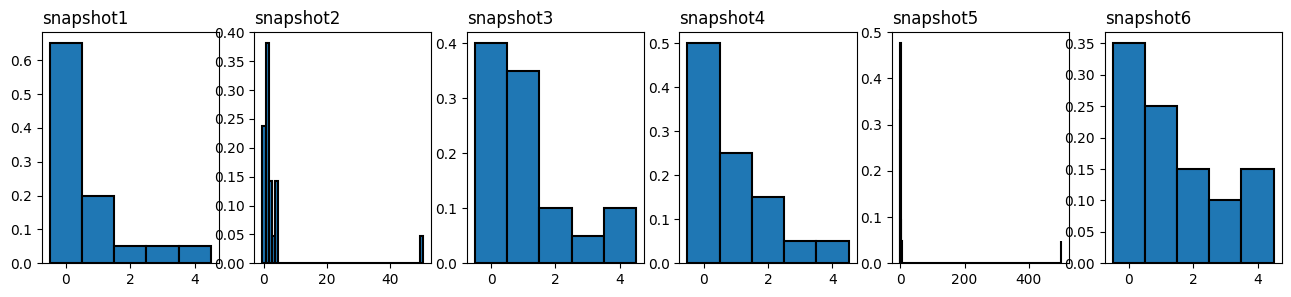

In [184]:
fig, axs = plt.subplots(1, 6, figsize=(16,3))
snapshot_sums = {}
for index, value in enumerate(snapshots.keys()):
    snapshot_sums[value] = sum(snapshots[value])
    data_incoming = snapshots[value]
    unique_values = np.unique(data_incoming)
    if np.all(unique_values) == 0:
        d = 1
    else:
        d = np.diff(unique_values).min()
    left_of_first_bin = data_incoming.min() - float(d)/2
    right_of_last_bin = data_incoming.max() + float(d)/2
    
    axs[index].hist(data_incoming, np.arange(left_of_first_bin, right_of_last_bin + d, d), edgecolor='black', linewidth=1.5, density=True)
    axs[index].set_title(value, loc='left', fontsize=12)
    
plt.show()

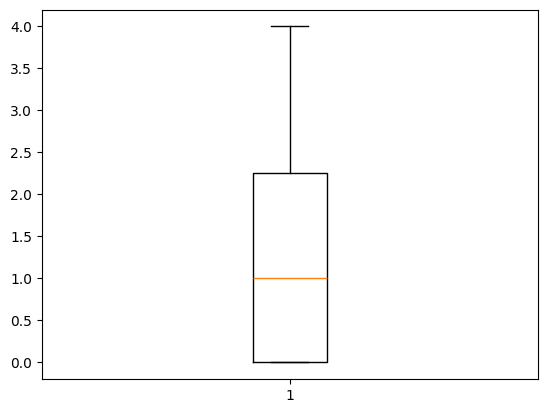

In [185]:
plt.boxplot(data_incoming, whis=(0,100))
plt.show()

#### Total incoming defects per snapshot

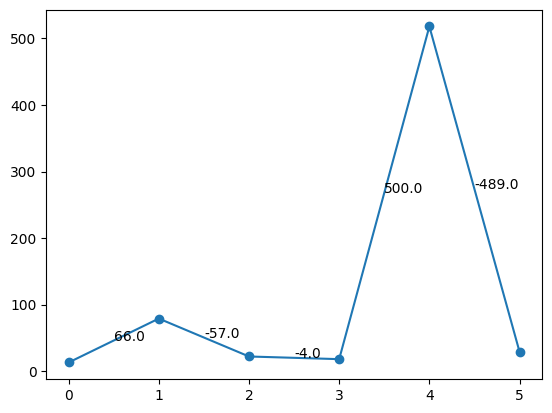

In [217]:
sums = list(snapshot_sums.values())
slopes, midpoints_x, midpoints_y = [], [], []
# slopes = [round(np.polyfit([i+1,i+2], [sums[i],sums[i+1]], 1)[0],1) for i in range(len(sums)-1)]
# midpoints_x = [(2*i+1)/2 for i in range(len(sums)-1)]
# midpoints_y = [(sums[i]+sums[i+1])/2 for i in range(len(sums)-1)]
plt.plot(sums, '-o')
for i in range(len(sums)-1):
    slopes.append(round(np.polyfit([i+1,i+2], [sums[i],sums[i+1]], 1)[0],1))
    midpoints_x.append((2*i+1)/2)
    midpoints_y.append((sums[i]+sums[i+1])/2)
    plt.text(midpoints_x[i], midpoints_y[i], slopes[i])
plt.show()